In [1]:
from worldLoader import WorldSlice
import interfaceUtils
import commandUtils

In [110]:
buildarea = commandUtils.makeBuildArea(64, 64)
buildarea

(576, 2828, 64, 64)

In [111]:
ws = WorldSlice(buildarea)

getting chunks 36 176 4 5 
request url: http://localhost:9000/chunks?x=36&z=176&dx=4&dz=5
result: 200
parsing NBT
extracting heightmaps
extracting chunk sections
done


In [96]:
# Get information about one block
#block = ws.getBlockCompoundAt((39, 0, -269))
print(block)
name = block["Name"]

IndexError: list index out of range

In [99]:
str(name)

'minecraft:air'

In [112]:
# ws.getBlockAt((x,y,z)) -- get name of block. Fall back into air if chunck not loaded
# ws.getBlockCompoundAt((x,y,z)) -- get all info of block (NBT) in properties. Return None if chunk not loaded)

blocks = {}
NoneBlocks = []
for x in range(buildarea[0],buildarea[0]+buildarea[2]):
    for z in range(buildarea[1],buildarea[1]+buildarea[3]):
        for y in range(0,255):
            # b = ws.getBlockCompoundAt((x,y,z))
            b = ws.getBlockAt((x,y,z))
            if b:
                # name = str(b["Name"]) # properties of getBlockCompound are NBT
                name = b
            else:
                name = "None" # Fully air chunks are not loaded. gBCA gives "None"
                NoneBlocks.append((x,y,z))
                break
            if name in blocks.keys():
                blocks[name] = blocks[name] + 1
            else:
                blocks[name] = 1

In [101]:
len(NoneBlocks)

0

In [113]:
blocks

{'minecraft:bedrock': 12271,
 'minecraft:andesite': 5538,
 'minecraft:diorite': 7216,
 'minecraft:stone': 108788,
 'minecraft:granite': 6086,
 'minecraft:coal_ore': 1978,
 'minecraft:gravel': 5508,
 'minecraft:water': 101409,
 'minecraft:air': 786432,
 'minecraft:cave_air': 1552,
 'minecraft:tall_seagrass': 798,
 'minecraft:seagrass': 231,
 'minecraft:redstone_ore': 510,
 'minecraft:iron_ore': 1013,
 'minecraft:kelp_plant': 1321,
 'minecraft:kelp': 242,
 'minecraft:lava': 1206,
 'minecraft:dirt': 2077,
 'minecraft:gold_ore': 170,
 'minecraft:diamond_ore': 35,
 'minecraft:lapis_ore': 59,
 'minecraft:sand': 14,
 'minecraft:obsidian': 19,
 'minecraft:magma_block': 7}

In [105]:
#heightmaps
import mapUtils

In [116]:
heightmap = ws.heightmaps["OCEAN_FLOOR"]

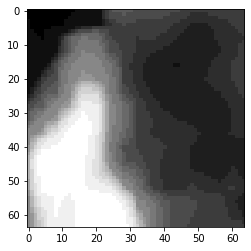

In [117]:
mapUtils.visualize(heightmap)

In [120]:
#visualize map
import cv2
import matplotlib.pyplot as plt
import numpy as np
import blockColors

heightmap = ws.heightmaps["MOTION_BLOCKING"]

hm = np.array(heightmap, dtype=np.uint8)
gradientX = cv2.Scharr(hm, cv2.CV_16S, 1, 0)
gradientY = cv2.Scharr(hm, cv2.CV_16S, 0, 1)

# This should be pre-calculated...
palette = {}
for hex, blocks in blockColors.PALETTE.items():
    for block in blocks:
        palette[block] = hex
        
        
# create a 2d map containing the surface block colors
topcolor = np.zeros((buildarea[2], buildarea[3]), dtype='int')
unknownBlocks = set()

for dx in range(buildarea[2]):
        for dz in range(buildarea[3]):
            # check up to 5 blocks below the heightmap
            for dy in range(5):
                # calculate absolute coordinates
                x = buildarea[0] + dx
                z = buildarea[1] + dz
                y = int(hm[(dx, dz)]) - dy

                blockID = ws.getBlockAt((x, y, z))
                if blockID in blockColors.TRANSPARENT:
                    # transparent blocks are ignored
                    continue
                else:
                    if blockID not in palette:
                        # unknown blocks remembered for debug purposes
                        unknownBlocks.add(blockID)
                    else:
                        topcolor[(dx, dz)] = palette[blockID]
                    break

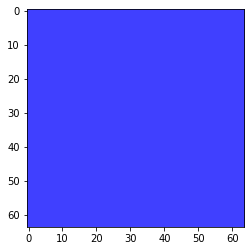

In [121]:
# separate the color map into three separate color channels
topcolor = cv2.merge(((topcolor) & 0xff, (topcolor >> 8)
                      & 0xff, (topcolor >> 16) & 0xff))

# calculate a brightness value from the gradient
brightness = np.expand_dims((gradientX + gradientY).astype("int"), 2)
brightness = brightness.clip(-64, 64)

topcolor += brightness
topcolor = topcolor.clip(0, 255)

# display the map
topcolor = topcolor.astype('uint8')
topcolor = np.transpose(topcolor, (1, 0, 2))
plt_image = cv2.cvtColor(topcolor, cv2.COLOR_BGR2RGB)

plt.imshow(plt_image)
plt.show()